# CNN from scratch - More explanation on the convolutions.

## Explaining the forward pass of the Conv2d layer using unfold operations

### Default image

The original image is a 28x28 grayscale image. We can plot it to see how it looks:

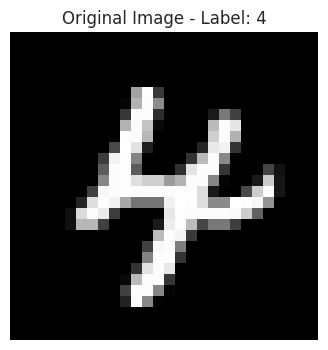

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = datasets.MNIST('../data/raw/', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a single image
dataiter = iter(loader)
image, label = next(dataiter)

# Plot the original image
plt.figure(figsize=(4, 4))
plt.imshow(image[0][0], cmap='gray')
plt.title(f'Original Image - Label: {label.item()}')
plt.axis('off')
plt.show()

In [9]:
print(image.shape, label.shape)

torch.Size([1, 1, 28, 28]) torch.Size([1])


### Padding

We apply padding to the image to maintain the spatial dimensions after convolution (only if stride is 1), and in particular to apply convolutions on pixels near the borders of the image. The filter will extend outside the original image for padding named `same`, while sliding through pixels at a kernel_size distance (or more) for padding `valid`.  

In this notebook, we implement and try to understand convolutions using padding `same`.

Shape of padded image : torch.Size([1, 1, 30, 30]) with padding (1, 1)


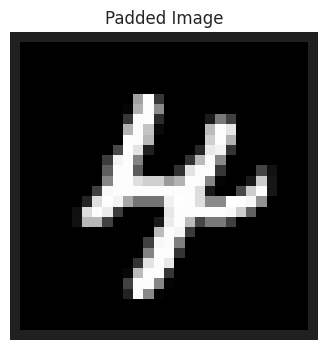

In [10]:
import torch.nn.functional as F

# let's suppose a kernel size of 3x3 and stride of 1
kernel_size = (3, 3)
stride = (1, 1)

padding = tuple((s * (k - 1) // 2 for s, k in zip(stride, kernel_size)))
padded_image_using_same = F.pad(image, (padding[1], padding[1], padding[0], padding[0]))
print(f"Shape of padded image : {padded_image_using_same.shape} with padding {padding}")

# Plot the padded image
plt.figure(figsize=(4, 4))
plt.imshow(padded_image_using_same[0][0], cmap='gray')
plt.title('Padded Image')
plt.axis('off')
plt.show()

### Unfolding

The unfold operation transforms the input tensor into a series of columns, each representing a patch of the image that will be convolved with the filter. This operation makes it easier to perform convolution as a matrix multiplication.

With .unfold, we first flatten along the height, then along the width, using the kernel size and stride.

In [11]:
unfolded_image = padded_image_using_same.unfold(2, kernel_size[0], stride[0])
print(f"Shape of the unfolded image: {unfolded_image.shape}")

unfolded_image_2nd = unfolded_image.unfold(3, kernel_size[1], stride[1])
print(f"Shape of the unfolded image: {unfolded_image_2nd.shape}") 

Shape of the unfolded image: torch.Size([1, 1, 28, 30, 3])
Shape of the unfolded image: torch.Size([1, 1, 28, 28, 3, 3])


Notice that the 2 last dimensions are the kernel_size, we can perform easily a matrix multiplication with a filter over these dimensions. For each pixel, we got a patch of the desired kernel size.

Unfolding is hard to visualize due to the high dimensionality of the tensors involved. What we have to keep in mind, is that for the convolutions, we want to create the patches of the image that will be convolved with the filter. This is done by sliding the filter over the extracted patches from the image.

An equivalent operation using for loops would be :
```python	
patches = []
for batch in range(batch_size):
    for channel in range(in_channels):
        for i in range(0, H, stride): # H is height of the image
            for j in range(0, W, stride): # W is weight of the image
                patch = x[batch, channel, i:i+kernel_size, j:j+kernel_size]
                patches.append(patch.flatten())
```
Using for loops is obviously slower than using .unfold, as we can parallelize the operations across the different dimensions of the tensor.

### The convolution using matrix multiplication

Shape of the weight tensor: torch.Size([1, 1, 3, 3])


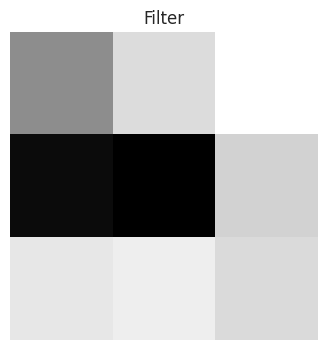

Shape of the weight tensor aligned: torch.Size([9, 1])


In [12]:
# Convolution filter
weight = torch.randn(1, 1, kernel_size[0], kernel_size[1])
print(f"Shape of the weight tensor: {weight.shape}")

# Plot the filter
plt.figure(figsize=(4, 4))
plt.imshow(weight[0][0], cmap='gray')
plt.title('Filter')
plt.axis('off')
plt.show()

weight = weight.view(1, -1).t().contiguous()
print(f"Shape of the weight tensor aligned: {weight.shape}")

Height and Width is kept the same as original only if the stride is 1, else it is reduced.

In [13]:
height, width = unfolded_image_2nd.shape[2], unfolded_image_2nd.shape[3] 

Shape of the unfolded image: torch.Size([1, 9, 28, 28, 1])
Shape of the output tensor: torch.Size([1, 1, 28, 28])


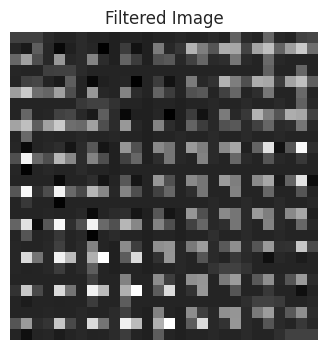

In [14]:
# Reshape the unfolded image
unfolded_image = unfolded_image_2nd.permute(0, 2, 3, 1, 4, 5).contiguous().view(1, height, width, 1, -1)
# -> dims are reordered to [batch_size, height, width, in_channels, kernel_height, kernel_width]
# -> contiguous() is called to ensure that the tensor is stored in a contiguous block of memory (necessary for view)
# -> view is called to reshape the tensor to [batch_size, height, width, in_channels, kernel_height * kernel_width]
unfolded_image = unfolded_image.permute(0, 4, 1, 2, 3).contiguous()
# -> dims are reordered to [batch_size, kernel_height * kernel_width, height, width, in_channels]
print(f"Shape of the unfolded image: {unfolded_image.shape}")

# perform the convolution operation
output = unfolded_image.view(1 * height * width, 1, -1).matmul(weight).view(1, height, width, 1).permute(0, 3, 1, 2)
# -> dims are reshaped to [batch_size * height * width, in_channels, kernel_height * kernel_width]
# -> the convolution operation is performed by matrix multiplication
# -> dims are reshaped back to [batch_size, height, width, out_channels]
# -> the output tensor is permuted to [batch_size, out_channels, height, width]
print(f"Shape of the output tensor: {output.shape}")

# Plot the output image
plt.figure(figsize=(4, 4))
plt.imshow(output[0][0], cmap='gray')
plt.title('Filtered Image')
plt.axis('off')
plt.show()

a bias can be added simply by adding a random tensor to the output of the convolution.